<a href="https://colab.research.google.com/github/alexchtst-01/METR-LA/blob/main/METR-LA_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Module

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy as dc

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold

### Deeplearning Model and Function

In [3]:
def data_with_lookback(df, n_steps):
    df = dc(df)
    col = df.columns
    df.set_index('Time', inplace=True)
    for i in range(1, n_steps+1):
        df[f'{col[1]}(t-{i})'] = df[f'{col[1]}'].shift(i)

    df.dropna(inplace=True)

    return df

In [4]:
class TimeSeriesData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.reshape(torch.tensor(X), (X.shape[0], X.shape[1]))
        self.y = torch.reshape(torch.tensor(y), (y.shape[0], y.shape[1]))

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [5]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #.to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #.to(device)

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [6]:
class GeneralLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GeneralLSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)

  def forward(self, x):
    out, _ = self.lstm(x)
    return out[:, -1, :]

### Data Preparartion

In [7]:
INDEX_IN_A_DAY = 288
NUMBER_OF_DAYS = 119

lookback = 6
total = INDEX_IN_A_DAY*NUMBER_OF_DAYS - 6
test_len = int(total*0.2)
train_len = total - test_len

ss = StandardScaler()
mm = MinMaxScaler()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

device = "cuda" if torch.cuda.is_available() else "cpu"
modelpath = "/content/drive/MyDrive/model/METR-LA/model3.pt"
graphpath = "/content/drive/MyDrive/model/METR-LA/GraphResult/"
device

'cpu'

In [8]:
data716328_path = "/content/drive/MyDrive/data/METR-LA/raw_data/716328.csv"
data716331_path = "/content/drive/MyDrive/data/METR-LA/raw_data/716331.csv"
data716337_path = "/content/drive/MyDrive/data/METR-LA/raw_data/716337.csv"
data716339_path = "/content/drive/MyDrive/data/METR-LA/raw_data/716339.csv"

data716328 = pd.read_csv(data716328_path)
data716331 = pd.read_csv(data716331_path)
data716337 = pd.read_csv(data716337_path)
data716339 = pd.read_csv(data716339_path)

In [9]:
data = data_with_lookback(data716328, lookback)

In [10]:
X, y = data.iloc[:, 1:], data.iloc[:, 0]
X, y  = X.to_numpy(), y.to_numpy().reshape(-1, 1)

# normalize data
X = ss.fit_transform(X)
y = mm.fit_transform(y)

# spliting data
X_train, X_test = X[:train_len, :], X[train_len:, :]
y_train, y_test = y[:train_len], y[train_len:]

mseArray = []
stdArray = []

In [11]:
X_train.shape

(27413, 6)

## Training Model

In [12]:
LEARNING_RATE = 0.005
EPOCHS = 10
BACTH_SIZE = INDEX_IN_A_DAY

input_size = 6
hidden_size = 5
num_layers = 2
output_size = 1

### General Model

in folds: 1 Epoch: 1
train loss: 0.10903948427386423
test loss: 0.025540727798531098
in folds: 1 Epoch: 2
train loss: 0.089056621634783
test loss: 0.024120528167176615
in folds: 1 Epoch: 3
train loss: 0.08848945349369035
test loss: 0.02414459718566589
in folds: 1 Epoch: 4
train loss: 0.0901388296008376
test loss: 0.02330378989726184
in folds: 1 Epoch: 5
train loss: 0.09001856765435581
test loss: 0.023906256187276823
in folds: 1 Epoch: 6
train loss: 0.08979901216630856
test loss: 0.023635183534540243
in folds: 1 Epoch: 7
train loss: 0.08869693130133859
test loss: 0.023871560665962865
in folds: 1 Epoch: 8
train loss: 0.08971783940690244
test loss: 0.023803320924133464
in folds: 1 Epoch: 9
train loss: 0.08834344992534571
test loss: 0.02378422928370631
in folds: 1 Epoch: 10
train loss: 0.08932009735719551
test loss: 0.023832476451132165
fold: 1 mse: 130.67346838155765
fold: 1 std: 0.0005930464249104261
in folds: 2 Epoch: 1
train loss: 0.11381825616259969
test loss: 0.022097142303810158
in 

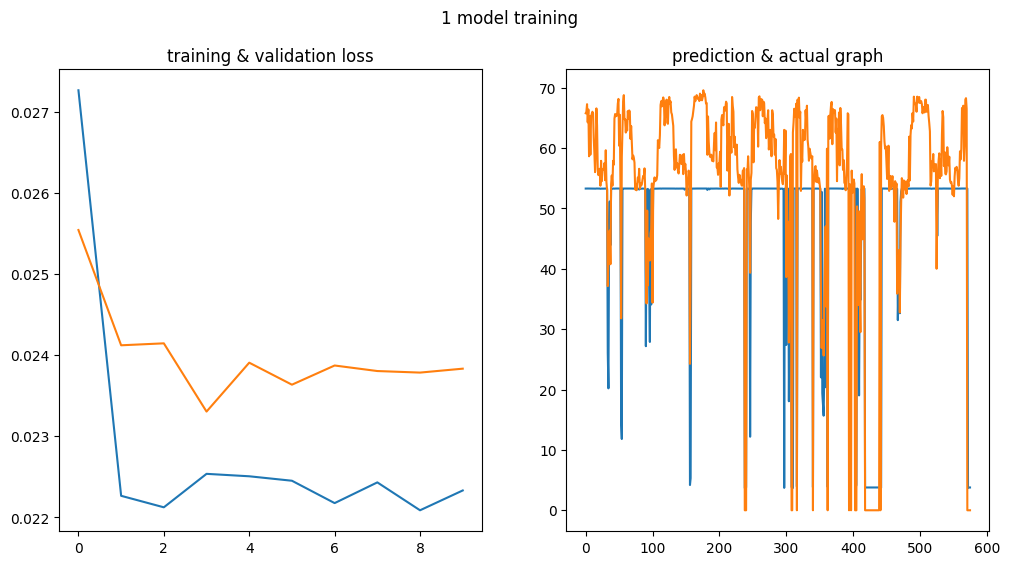

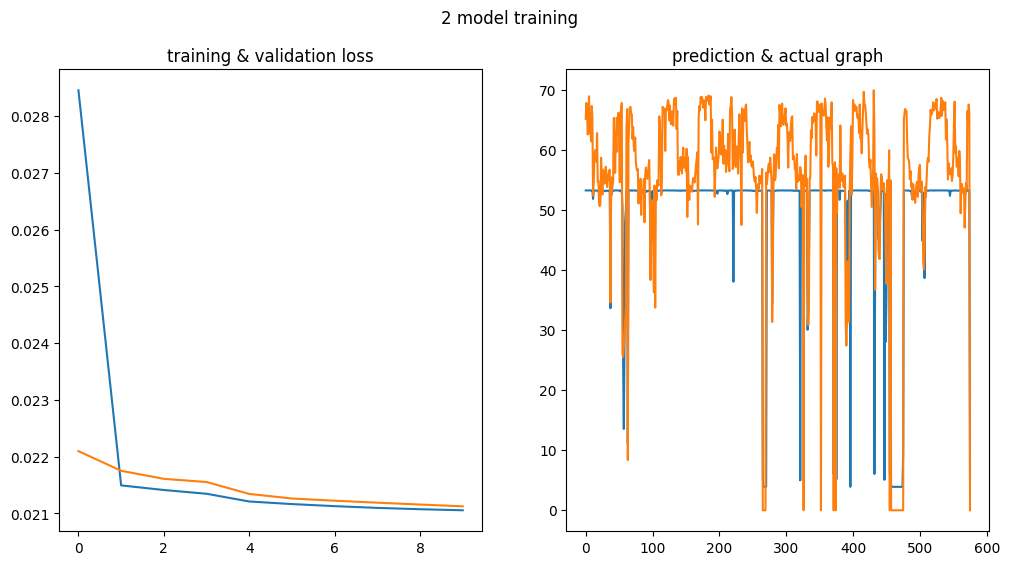

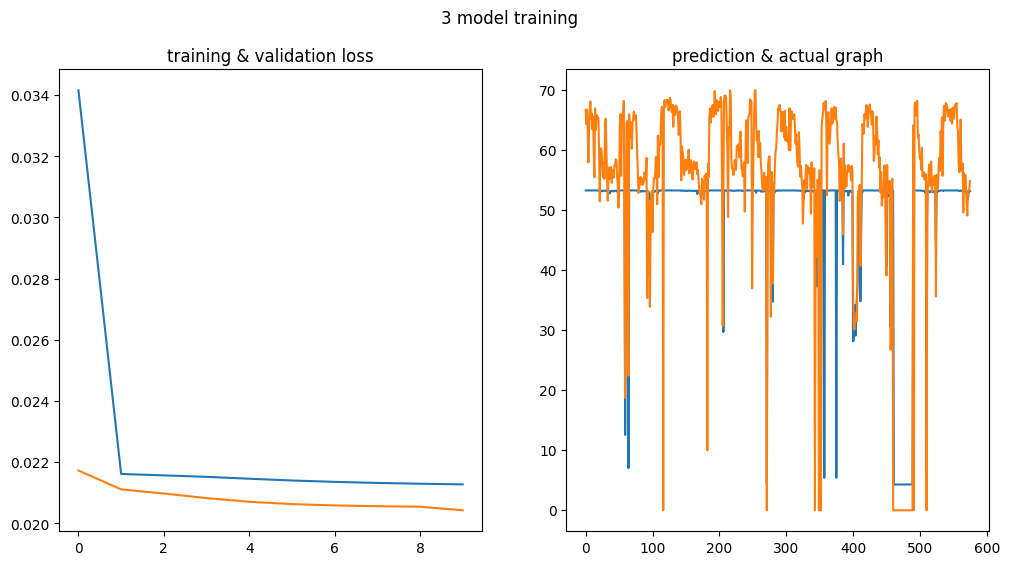

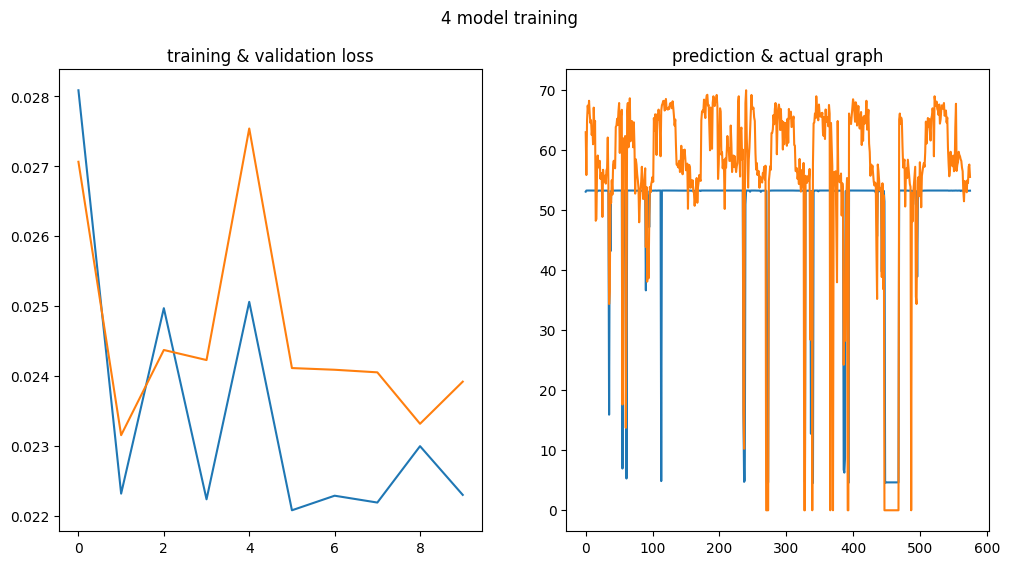

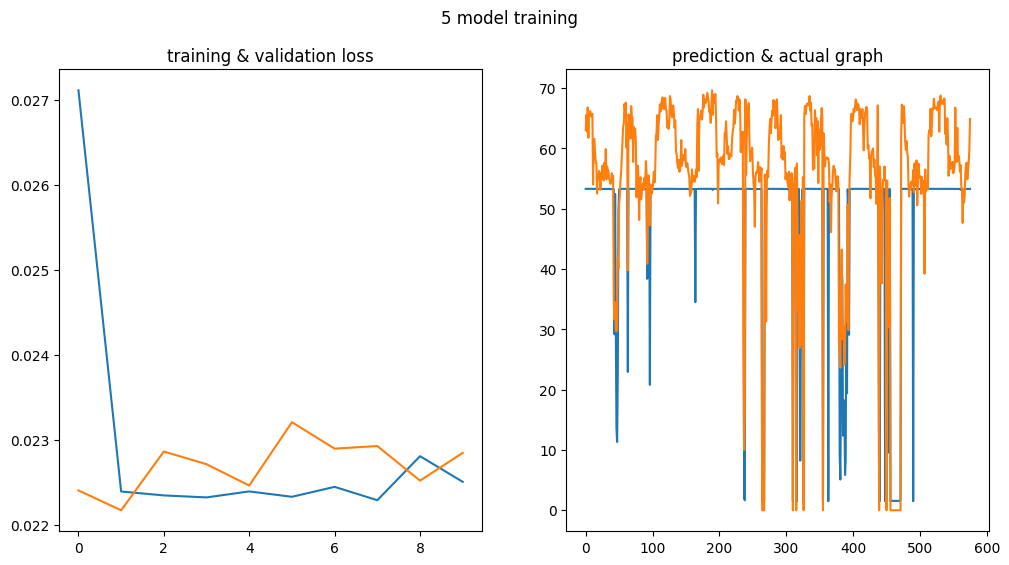

In [13]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
  train_error_store = []
  test_error_store = []

  X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
  y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

  train_dataset = TimeSeriesData(X_train_fold, y_train_fold)
  test_dataset = TimeSeriesData(X_val_fold, y_val_fold)

  train_loader = DataLoader(train_dataset)
  test_loader = DataLoader(test_dataset)

  model_general = GeneralLSTM(input_size=input_size, num_layers=num_layers, hidden_size=output_size)
  optimizer = optim.Adam(model_general.parameters(), lr=LEARNING_RATE)
  criterion = nn.MSELoss()

  for epoch in range(EPOCHS):
    model_general.train(True)
    train_running_loss = 0.0
    for idx, data in enumerate(train_loader):
        seq = data[0].float() #.to(device)
        out = data[1].float() #.to(device)
        optimizer.zero_grad()
        pred = model_general(seq.unsqueeze(0))
        loss = criterion(pred, out)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_error_store.append(train_running_loss / (idx+1))

    model_general.eval()
    eval_running_loss = 0.0
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            seq = data[0].float() #.to(device)
            out = data[1].float() #.to(device)
            pred = model_general(seq.unsqueeze(0))
            loss = criterion(pred, out)
            eval_running_loss += loss.item()
        test_error_store.append(eval_running_loss / (idx+1))

    print(f"in folds: {fold+1} Epoch: {epoch+1}")
    print(f"train loss: {train_running_loss / (idx+1)}")
    print(f"test loss: {eval_running_loss / (idx+1)}")

  predictions = []
  act_val = []
  for idx, data in enumerate(test_loader):
    with torch.no_grad():
        seq = data[0].float() #.to(device)
        pred = model_general(seq.unsqueeze(0))
        act_val.append(data[1].float().cpu().detach().numpy()[0])
        predictions.append(pred.cpu().detach().numpy()[0])

  print(f"fold: {fold+1} mse: {eval_running_loss}")
  print(f"fold: {fold+1} std: {torch.std(torch.tensor(test_error_store).float())}")

  mseArray.append(eval_running_loss)
  stdArray.append(torch.tensor(test_error_store).float())

  predictions_inverse_scale = mm.inverse_transform(predictions)
  actual_value = mm.inverse_transform(act_val)

  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  fig.suptitle(f"{fold+1} model training")

  ax[0].set_title("training & validation loss")
  ax[0].plot(train_error_store, label="train error")
  ax[0].plot(test_error_store, label="test error")

  ax[1].set_title("prediction & actual graph")
  ax[1].plot(predictions_inverse_scale[:INDEX_IN_A_DAY*2], label="prediction")
  ax[1].plot(actual_value[:INDEX_IN_A_DAY*2], label="actual value")
  plt.savefig(f"{graphpath}generalmodel_{fold+1}.png")

### Custom Model

Epoch: 1
train loss: 0.04788104457416305
test loss: 0.017141065607491564
Epoch: 2
train loss: 0.0332634923818787
test loss: 0.014920387948272901
Epoch: 3
train loss: 0.032684337704540115
test loss: 0.013729944681773538
Epoch: 4
train loss: 0.032310984034071774
test loss: 0.014886063506624815
Epoch: 5
train loss: 0.03204929560686955
test loss: 0.014435167567898484
Epoch: 6
train loss: 0.031872034700925346
test loss: 0.014285653938385694
Epoch: 7
train loss: 0.03218275098397924
test loss: 0.01377859759705661
Epoch: 8
train loss: 0.03181046053349393
test loss: 0.013533882087523917
Epoch: 9
train loss: 0.03134684994649757
test loss: 0.014428372484675624
Epoch: 10
train loss: 0.031629183666767216
test loss: 0.01458520223341181
fold: 1 mse: 79.97066384579695
fold: 1 std: 0.0010196875082328916
Epoch: 1
train loss: 0.044085553253177034
test loss: 0.01911073282054448
Epoch: 2
train loss: 0.036150867312239404
test loss: 0.016590645735683317
Epoch: 3
train loss: 0.03465816750178574
test loss: 0.0

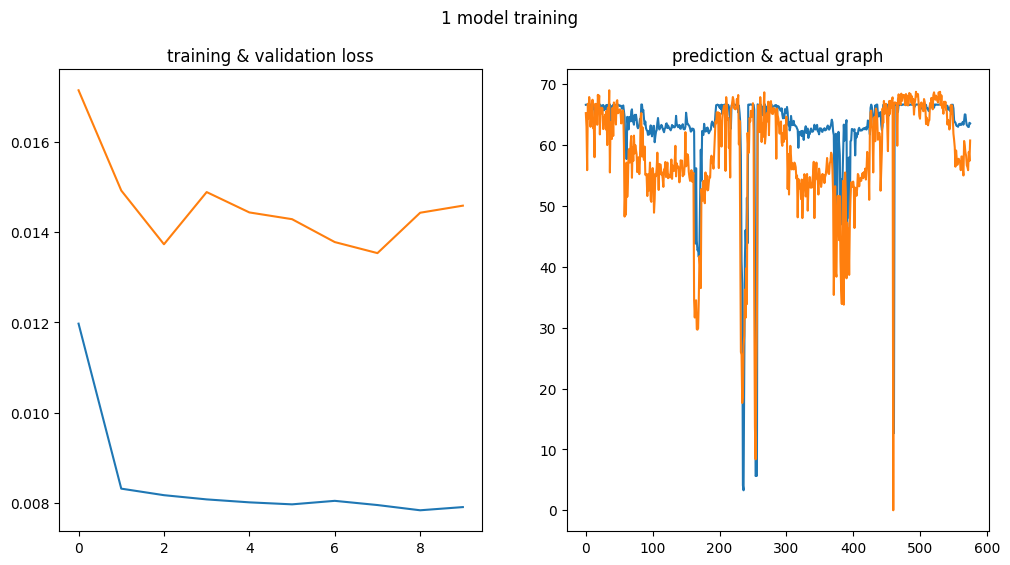

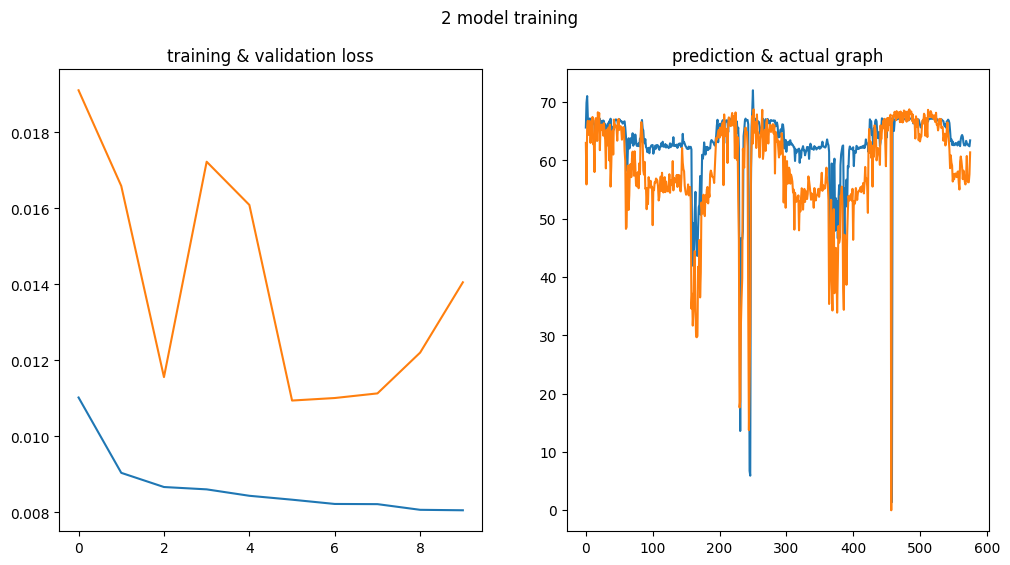

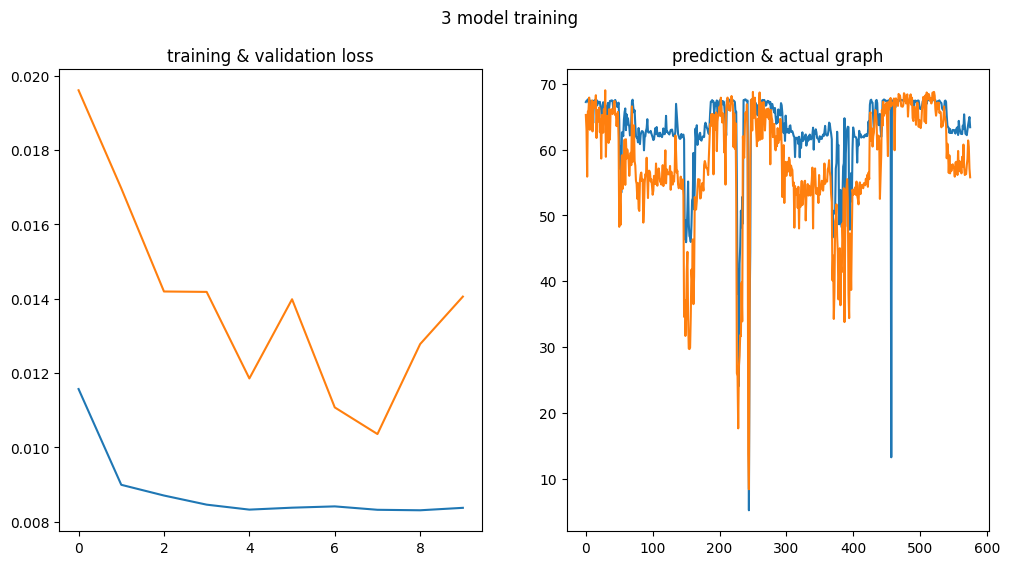

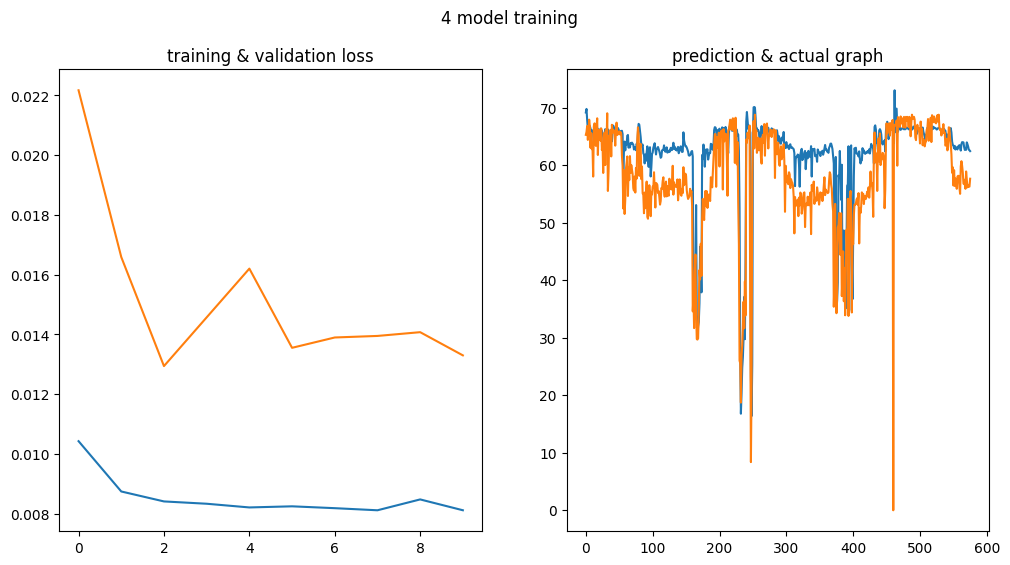

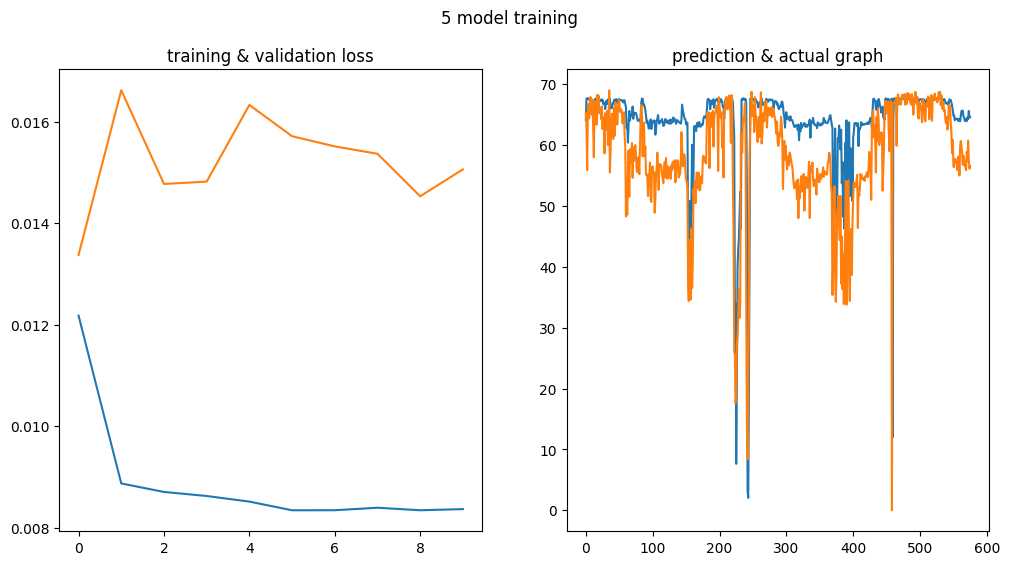

In [14]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
  train_error_store = []
  test_error_store = []

  X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
  y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

  train_dataset = TimeSeriesData(X_train_fold, y_train_fold)
  test_dataset = TimeSeriesData(X_val_fold, y_val_fold)

  train_loader = DataLoader(train_dataset)
  test_loader = DataLoader(test_dataset)

  model = CustomLSTM(input_size, hidden_size, num_layers, output_size) #.to(device)
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
  criterion = nn.MSELoss()

  for epoch in range(EPOCHS):
    model.train(True)
    train_running_loss = 0.0
    for idx, data in enumerate(train_loader):
        seq = data[0].float() #.to(device)
        out = data[1].float() #.to(device)
        optimizer.zero_grad()
        pred = model(seq.unsqueeze(0))
        loss = criterion(pred, out)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_error_store.append(train_running_loss / (idx+1))

    model.eval()
    eval_running_loss = 0.0
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            seq = data[0].float() #.to(device)
            out = data[1].float() #.to(device)
            pred = model(seq.unsqueeze(0))
            loss = criterion(pred, out)
            eval_running_loss += loss.item()
        test_error_store.append(eval_running_loss / (idx+1))

    print(f"Epoch: {epoch+1}")
    print(f"train loss: {train_running_loss / (idx+1)}")
    print(f"test loss: {eval_running_loss / (idx+1)}")

  predictions = []
  act_val = []
  for idx, data in enumerate(train_loader):
    with torch.no_grad():
        seq = data[0].float() #.to(device)
        pred = model(seq.unsqueeze(0))
        act_val.append(data[1].float().cpu().detach().numpy()[0])
        predictions.append(pred.cpu().detach().numpy()[0])

  print(f"fold: {fold+1} mse: {eval_running_loss}")
  print(f"fold: {fold+1} std: {torch.std(torch.tensor(test_error_store).float())}")


  mseArray.append(eval_running_loss)
  stdArray.append(torch.tensor(test_error_store).float())

  predictions_inverse_scale = mm.inverse_transform(predictions)
  actual_value = mm.inverse_transform(act_val)

  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  fig.suptitle(f"{fold+1} model training")

  ax[0].set_title("training & validation loss")
  ax[0].plot(train_error_store, label="train error")
  ax[0].plot(test_error_store, label="test error")

  ax[1].set_title("prediction & actual graph")
  ax[1].plot(predictions_inverse_scale[:INDEX_IN_A_DAY*2], label="prediction")
  ax[1].plot(actual_value[:INDEX_IN_A_DAY*2], label="actual value")

  plt.savefig(f"{graphpath}custommodel_{fold+1}.png")

In [30]:
test_len

6853

In [28]:
for i in mseArray:
  print(i)

130.67346838155765
115.8219240187718
112.00433875935931
131.12156773216344
125.260721673861
79.97066384579695
77.065693330834
77.07022798561165
72.88623256076296
82.55585856773814


In [29]:
for i in range(len(stdArray)):
  print(f"std:", mm.inverse_transform(torch.std(stdArray[i]).cpu().detach().numpy().reshape(1, -1)))

std: [[0.04151325]]
std: [[0.02214668]]
std: [[0.02695354]]
std: [[0.10415767]]
std: [[0.02150108]]
std: [[0.07137813]]
std: [[0.21302861]]
std: [[0.19273531]]
std: [[0.19226527]]
std: [[0.06515419]]
